# SigBERT *(P. Minchella et al., 2025)*

This notebook is an application companion to the paper:

**SigBERT: Combining Narrative Medical Reports and Rough Path Signature Theory for Survival Prediction in Oncology**

---

## Summary of the Method

The pipeline performs time-to-event prediction using longitudinal narrative data, following these steps:

1. **Sentence Embeddings**: Each medical report is transformed into a high-dimensional vector (typically using a language model such as OncoBERT (RoBERTa-based architecture).
2. **Dimensionality Reduction**: A linear compression (e.g., Johnson-Lindenstrauss mapping or PCA) reduces the embedding size for computational efficiency.
3. **Signature Extraction**: Path signature theory (up to order 2 or 3) is applied to capture the time dynamics of these compressed embeddings.
4. **Survival Modeling**: A LASSO-regularized Cox model is trained on these signature features to estimate risk scores and survival times.
5. **Evaluation**: C-index, time-dependent AUC, Brier Score, and Integrated Brier Score (IBS) are used for evaluation, with extensive validation over varying observation depths.

---

## Requirements for Using This Notebook with Your Data

Ensure your column names follow the naming convention described in the README.

**Note**: If your dataset only provides the event duration (in days) without an explicit `date_start`, you can create `date_start` by subtracting the duration from a fixed reference date such as `"1970-01-01"` or `"2000-01-01"`. Then compute `date_end` by adding the duration.

Once your data is properly preprocessed, you're ready to run the notebook.

In [1]:
import types
import sys
from numbers import Real, Integral

# Create a fake module to emulate 'sklearn.utils._param_validation'
# (used by skglm in newer versions of scikit-learn, >=1.3)
param_validation = types.ModuleType("sklearn.utils._param_validation")

# Define a minimal replacement for Interval used in _parameter_constraints
class Interval:
    def __init__(self, dtype, left, right, closed="neither"):
        self.dtype = dtype
        self.left = left
        self.right = right
        self.closed = closed

# Define a minimal replacement for StrOptions used in _parameter_constraints
class StrOptions:
    def __init__(self, options):
        self.options = set(options)

# Add the custom classes to the fake module
param_validation.Interval = Interval
param_validation.StrOptions = StrOptions

# Inject the fake module into sys.modules before skglm is imported
# This prevents skglm from raising an ImportError if sklearn < 1.3
sys.modules["sklearn.utils._param_validation"] = param_validation

In [2]:
import pandas as pd
import torch
import numpy as np
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os

# Add the src directory to the Python path
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src/sigbert'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Now import our custom modules
from _utils import *
from descriptive_stats_pkg import *
from compression_pkg import *
from survival_analysis_pkg import *
from metrics_plot_results_pkg import *

In [5]:
start_notebook = time.time()

# I) Data Importation

In [6]:
df_OG = global_data_import(path_import = "../data/data_real.csv", nrows=None)


----- Total import time: 103.24 seconds (1.72 minutes)
Number of unique patients: 7121


In [7]:
df_OG = convert_date_columns(df_OG)
df_OG['date_death'] = df_OG['date_death'] - pd.to_timedelta(100, unit='D')

In [8]:
df_OG.head(3)

,ID,date_creation,DEATH,date_death,date_end,date_start,Source,embeddings
0,r-10102377,2003-12-19,1,2018-09-18,2018-12-27,2003-12-19,Compte-rendu de consultation,"[-0.0012410531159549923, 0.006474097617021355,..."
1,r-10102377,2015-05-19,1,2018-09-18,2018-12-27,2003-12-19,Compte-rendu de consultation,"[0.0019768097325207875, 0.02394500209960051, -..."
2,r-10102377,2014-04-23,1,2018-09-18,2018-12-27,2003-12-19,Compte-rendu de séjour,"[-0.00035438287161312324, 0.000483653710470340..."


In [9]:
print_dataset_statistics(df_OG)

Total number of patients in the dataset: 7121
Total number of medical reports: 274420
Average number of reports per patient: 38.54
Number of deceased patients: 5213
Number of censored patients: 1908


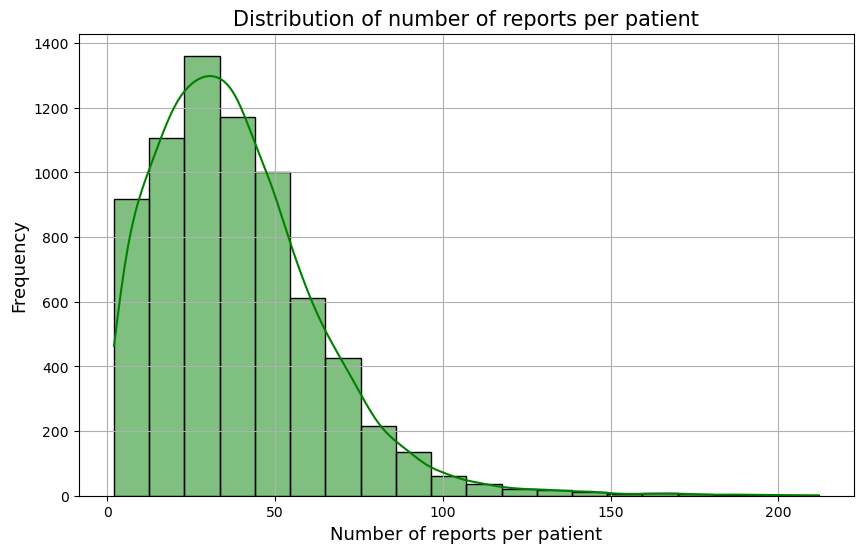

In [10]:
plot_report_distribution_per_patient(df_OG, export_path='../results/reports_per_patients.png')

# II) Training

In [11]:
Ndays = int((df_OG['date_end'] - df_OG['date_start']).min().days)
print(f"Ndays = {Ndays}")

# Imposes a maximum number of known reports
max_reports = 221

Ndays = 3


### Train-Test Split

In [12]:
df_train_new_OG, test_groups = make_train_test(df_OG)

In [13]:
k_comp = 25
_, R_comp = pca_compression(df_train_new_OG, k_comp, verbose = True)

Compression dimension (bar_p): 25
Explained variance ratio: 97.1010%


In [14]:
# Instance of results lists
c_index_test_results = []
df_survival_test_list = []
lambda_l1_CV = 0.7

In [15]:
df_all = df_OG.copy()

In [16]:
(
    df_results,               # Summary DataFrame with metrics for the current max_reports setup
    cph,                      # Trained Cox proportional hazards model
    df_survival,              # Survival data (event, time, risk_score) for the training set
    w_sk,                     # Risk scores for training patients
    scores,                   # Signature feature importance scores
    X,                        # Design matrix (features) used to train the model
    y_train,                  # Target array for survival analysis (event, time) before preprocess
    y_cox,                    # Target array for survival analysis (event, time)
    c_index_train,            # C-index on the training set
    c_index_test_list,        # List of C-index values on each test group
    c_index_test_mean,        # Mean C-index across test groups
    c_index_test_std,         # Standard deviation of C-index across test groups
    df_survival_test_list     # List of survival DataFrames for each test group
) = global_sigbert_process(
    max_reports,
    df_all,
    df_train_new_OG,
    test_groups,
    R_comp,
    lambda_l1_CV
)


### Processing for max_reports = 221 ###

Total number of individuals in the train set: 3560
Total number of individuals in the validation set: 3561

Timestamps normalized for each patient to the [0, 1] range.
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 2644 out of 3560 (74.27%)
Signature feature computation took 12.53s (0.21min).
 --------------- Linear LASSO training --------------- 


/Applications/anaconda3/envs/sigbert-env/lib/python3.8/site-packages/skglm/solvers/prox_newton.py:433: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  grad[idx] = X[:, j] @ raw_grad


Number of nonzero coefficients in solution: 33 out of 702.
C-index on training data: 0.737
Execution time: 13.91 seconds (0.23 minutes)

        Scores:
        C-index        = 0.737
        Log-likelihood = -5.16
        
 ---------------  --------------- 
Timestamps normalized for each patient to the [0, 1] range.
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 253 out of 357 (70.87%)

--- Test Case 1 for max_reports = 221 ---
Concordance index on test set: 0.731
--- ---
Timestamps normalized for each patient to the [0, 1] range.
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 254 out of 356 (71.35%)

--- Test Case 2 for max_reports = 221 ---
Concordance index on test set: 0.755
--- ---
Timestamps normalized for each patient to the [0, 1] range.
Number of signature components (order 2): 702
Percentage of rows with NaNs in

In [17]:
df_results

,Max Reports,Mean C-index,Std C-index,Total Deceased Patients,Total Censored Patients,Total Unique Patients,Total Number of Reports,Mean Study Time (days),Std Study Time (days),Execution Time (s),Mean Reports per Patient,Std Reports per Patient
0,221,0.750719,0.014281,5213,1908,7121,274420,1701.629,1806.134,41.12,38.537,24.884


## III) Results : Plots and metrics

In [18]:
print(f"Training c-index: {c_index_train:.3f}.")
print(f"Validation c-index: {c_index_test_mean:.3f} (sd {c_index_test_std:.4f}).")

Training c-index: 0.737.
Validation c-index: 0.751 (sd 0.0143).


In [19]:
lower_bound, upper_bound = jackknife_confidence_interval(c_index_test_list)

# Affichage des résultats
print(f"Jackknife Confidence Interval (95%): [{lower_bound:.4f}, {upper_bound:.4f}]")

Jackknife Confidence Interval (95%): [0.7419, 0.7596]


In [20]:
df_survival_test_overall = pd.concat(
[df_survival_test_list[i] for i in range(len(test_groups))],
    axis=0
)

In [21]:
df_survival_all = pd.concat([df_survival, df_survival_test_overall])

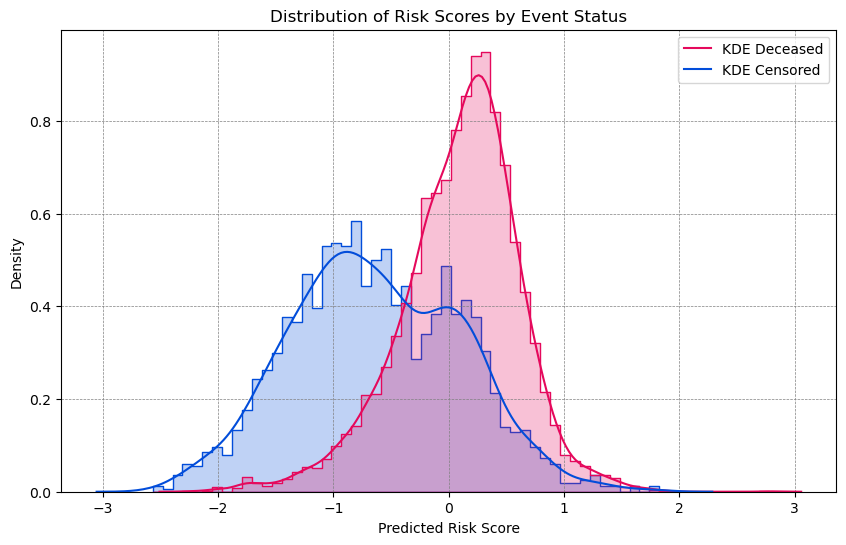

In [22]:
df_label, _ = plot_risk_score_distribution_by_event(
    df_survival_all,
    export_plot="../results/risk_score_distribution.png",
    use_ttest=False
)

In [23]:
results_corr, summary_corr = evaluate_correlation(df_survival_test_list, verbose=True)

Pearson correlation: -0.509 (sd 0.0351)
Pearson p-value: 1.444e-15 (sd 2.835e-15)

Spearman correlation: -0.522 (sd 0.0403)
Spearman p-value: 2.235e-14 (sd 6.698e-14)


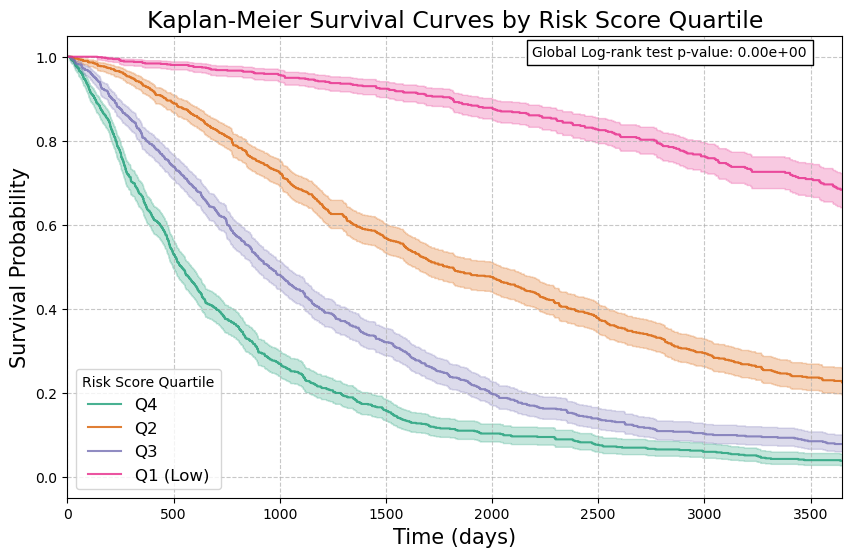

In [24]:
results_KM_pairwise, results_KM_global, quartile_groups = plot_km_by_risk_quartiles(
    df_survival_test_overall,
    export_fig=True,
    path_export_fig="../results/KM_by_quartiles.png",
    time_max_days=3650
)

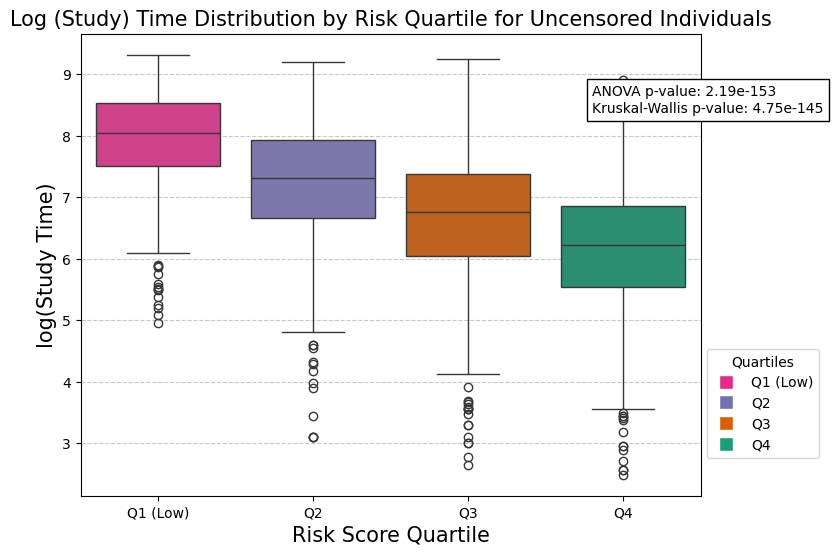

Number of uncensored individuals in Q1 (Low): 309.0 out of 891
Q1 (Low) - Median event time: 3126.00 days
Q1 (Low) - Mean event time: 3742.36 days

Number of uncensored individuals in Q2: 686.0 out of 890
Q2 - Median event time: 1488.50 days
Q2 - Mean event time: 1998.73 days

Number of uncensored individuals in Q3: 770.0 out of 890
Q3 - Median event time: 862.00 days
Q3 - Mean event time: 1207.13 days

Number of uncensored individuals in Q4: 804.0 out of 890
Q4 - Median event time: 502.00 days
Q4 - Mean event time: 812.30 days



In [25]:
# Assign quartiles to the DataFrame
df_survival_test_overall["Quartile"] = pd.qcut(
    df_survival_test_overall["risk_score"],
    q=4,
    labels=["Q1 (Low)", "Q2", "Q3", "Q4"]
)

# Now call the plotting function
anova_pval, kruskal_pval = plot_boxplot_log_time_by_quartile(
    df_survival=df_survival_test_overall, 
    quartile_groups=quartile_groups, 
    export_fig=True, 
    path_export_fig="../results/boxplot_log_time.png", 
    print_median_time=True
)

### td-AUC

Mean AUC for Test 1: 0.754
Mean AUC for Test 2: 0.815
Mean AUC for Test 3: 0.796
Mean AUC for Test 4: 0.769
Mean AUC for Test 5: 0.773
Mean AUC for Test 6: 0.766
Mean AUC for Test 7: 0.798
Mean AUC for Test 8: 0.798
Mean AUC for Test 9: 0.842
Mean AUC for Test 10: 0.833

Mean Dynamic AUC across all tests: 0.794
Standard Deviation of Dynamic AUC: 0.029


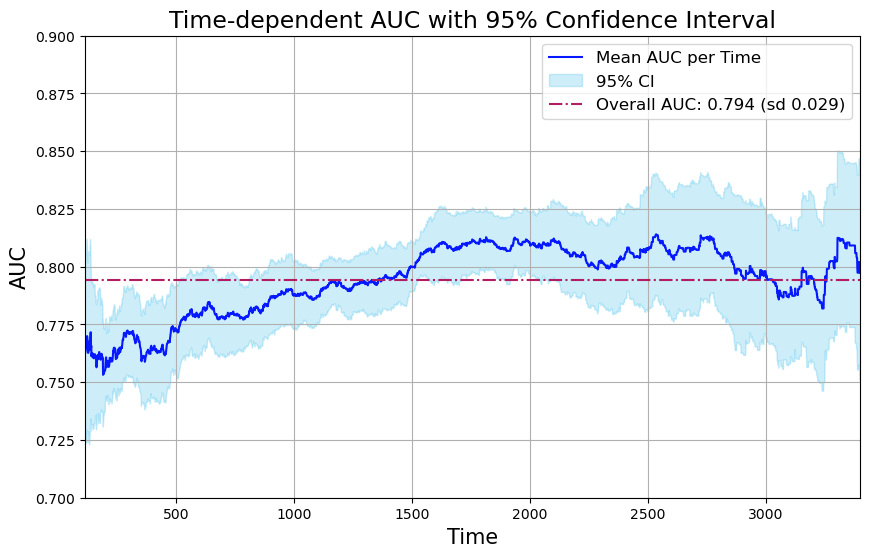

In [26]:
mean_auc_list, mean_auc_per_time, std_auc_per_time, times = plot_dynamic_auc(
    y_train,
    df_survival_test_list,
    test_groups,
    export_fig = '../results/time-dep-AUC-curves.png'
)

### Brier Score

Computing Brier Scores: 100%|███████████████████| 10/10 [00:04<00:00,  2.31it/s]



=== Brier Score Summary ===
Mean BS across tests: 0.2119
BS range: [0.0015 ;  0.4034]



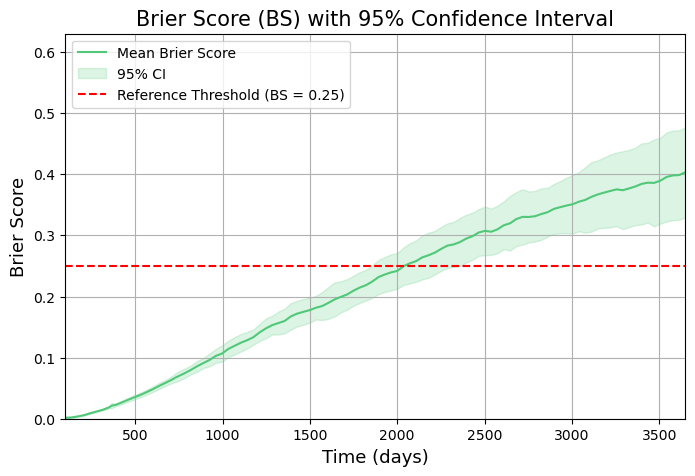

In [27]:
# Définir les temps d’évaluation
evaluation_times = np.linspace(100, 3650, 100)

# Ajouter des jalons cliniques
evaluation_times = np.sort(np.unique(np.concatenate((
    evaluation_times,
    [365, 730, 1095, 1825, 3650]
))))

# Appeler la méthode
brier_scores_array, bs_mean, bs_std, bs_upper, bs_lower = evaluate_brier_score_multiple_tests(
    df_survival_test_list=df_survival_test_list,
    cph=cph,
    evaluation_times=evaluation_times,
    brier_score_function=brier_score_ipcw_with_cph,
    export_fig=True,
    path_export_fig="../results/brier_score_tests.png",
    verbose=True
)

In [28]:
times_of_interest = [365, 701, 1095, 1825, 3650]

bs_results = summarize_brier_scores_at_times(
    evaluation_times=evaluation_times,
    bs_mean=bs_mean,
    bs_lower=bs_lower,
    bs_upper=bs_upper,
    times_of_interest=times_of_interest,
    verbose=True
)

BS at 1 year: Mean = 0.0214, Std = 0.0021
BS at 701 days: Mean = 0.0638, Std = 0.0029
BS at 3 years: Mean = 0.1230, Std = 0.0073
BS at 5 years: Mean = 0.2192, Std = 0.0130
BS at 10 years: Mean = 0.4034, Std = 0.0374


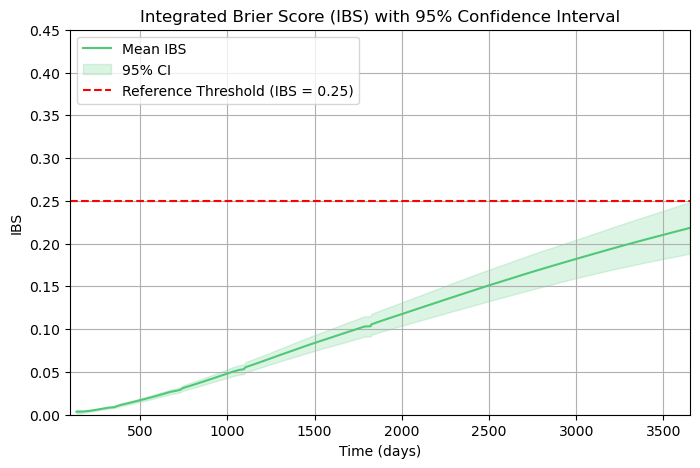

IBS at 1 year: Mean = 0.0098, Std = 0.0007
IBS at 701 days: Mean = 0.0281, Std = 0.0014
IBS at 3 years: Mean = 0.0532, Std = 0.0029
IBS at 5 years: Mean = 0.1055, Std = 0.0062
IBS at 10 years: Mean = 0.2183, Std = 0.0153


In [29]:
ibs_results = compute_and_plot_ibs_with_ci(
    evaluation_times=evaluation_times,
    bs_mean=bs_mean,
    bs_lower=bs_lower,
    bs_upper=bs_upper,
    times_of_interest=[365, 701, 1095, 1825, 3650],
    plot_baseline=0.25,
    verbose=True
)

## Validation C-index by number of known reports on our true cohort

In [30]:
df_combined = pd.read_csv('../results/c-index_by_nbr_reports_on_true_data.csv')

Figure saved to ../results/Mean_Cindex_by_reports.png


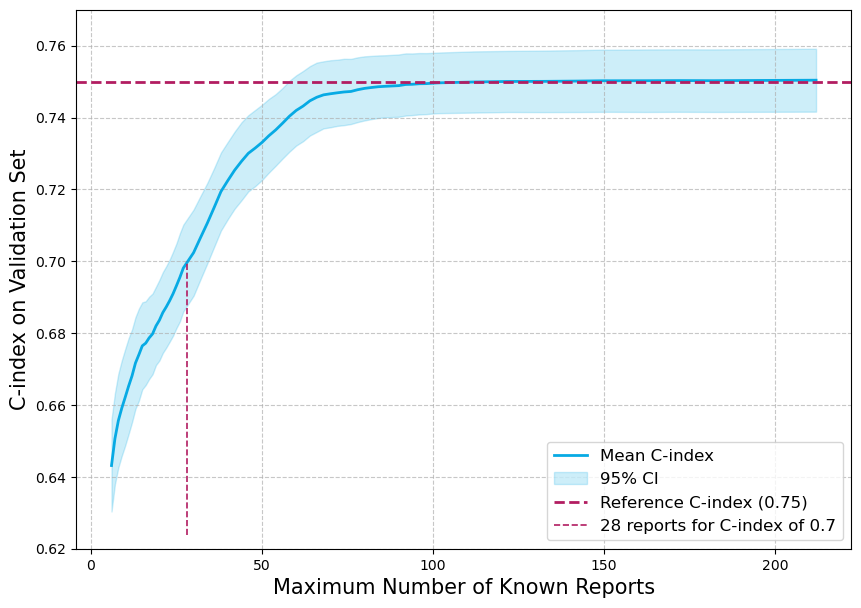

In [31]:
plot_smoothed_cindex_by_report_count(df_combined, export_path ='../results/Mean_Cindex_by_reports.png')

In [32]:
duration_notebook = time.time() - start_notebook
print(f" NoteBook total duration: {duration_notebook:.2f}s i.e. {duration_notebook / 60:.2f}min.")

 NoteBook total duration: 166.72s i.e. 2.78min.
